## Download the Visual Wake Words dataset and MCUNetV2 Model

**[Visual Wake Words Dataset](https://arxiv.org/abs/1906.05721)**

该数据集代表了一个常见的微控制器视觉应用场景：识别图像中是否存在人，并为小型视觉模型提供了一个实际的基准。

在 250 KB 的有限内存占用下，几个最先进(截止置2019.06)的移动模型在视觉唤醒词数据集上达到了 85-90% 的准确率。



**[MCUNetV2: Memory-Efficient Patch-based Inference for Tiny Deep Learning](https://arxiv.org/abs/2110.15352)**

由于微控制器单元 microcontroller units(MCU) 的内存容量有限，在微控制器单元上进行微型深度学习面临诸多挑战。我们发现，内存瓶颈源于卷积神经网络 (CNN) 设计中内存分布的不平衡：网络的前几个模块的内存使用量比其余部分高出一个数量级。

为了缓解这个问题，我们提出了一种通用的逐块推理调度方法(a generic patch-by-patch inference scheduling)，该方法仅对特征图的一小部分空间区域进行操作，从而显著降低了峰值内存占用。然而，简单的实现方式会导致块重叠和计算开销。我们进一步提出了一种网络重分布方法，将感受野和浮点运算 (FLOPs) 转移到后期阶段，从而降低计算开销。

手动重分布感受野非常困难。**我们利用神经网络架构搜索neural architecture search(NAS)实现该过程的自动化**，从而联合优化神经网络架构和推理调度，最终得到了 MCUNetV2。

基于块的推理(Patch-based inference)有效地将现有网络的峰值内存使用量降低了 4-8 倍。 

MCUNetV2 与神经网络协同设计，在 MCU 上创下了 ImageNet 数据集的最高准确率 (71.8%)，并在仅占用 32kB SRAM 的情况下，在视觉唤醒词数据集上实现了超过 90% 的准确率。

MCUNetV2 还突破了微型设备上的目标检测瓶颈，在 Pascal VOC 架构上实现了比现有最佳结果高出 16.9% 的 mAP。我们的研究在很大程度上解决了 tinyML 中的内存瓶颈问题，并为图像分类以外的各种视觉应用铺平了道路。

In [ ]:
# print("Cleanning up workspace ...")
# !rm -rf *
print("Downloading MCUNet codebase ...")
!wget https://www.dropbox.com/s/3y2n2u3mfxczwcb/mcunetv2-dev-main.zip?dl=0 >/dev/null
!unzip mcunetv2-dev-main.zip* 1>/dev/null
!mv mcunetv2-dev-main/* . 1>/dev/null
print("Downloading VWW dataset ...")
!wget https://www.dropbox.com/s/169okcuuv64d4nn/data.zip?dl=0 >/dev/null
print("Unzipping VWW dataset ...")
!unzip data.zip* 1>/dev/null
print("Installing thop and onnx ...")
# THOP = PyTorch-OpCounter（模型复杂度分析工具）, 给定一个 nn.Module，THOP 可以计算：
# FLOPs / MACs（乘加次数）, 参数量（#Params）
!pip install thop 1>/dev/null
# ONNX = Open Neural Network Exchange, 一种跨框架的神经网络中间表示（IR）+ 文件格式
# ONNX 解决不同深度学习框架互不兼容问题：PyTorch， TensorFlow，JAX， Caffe / MXNet
# ONNX 提供统一的“模型表示格式”
!pip install onnx 1>/dev/null
!pip install graphviz 1>/dev/null

Unzipping VWW dataset ...
Installing thop and onnx ...


In [14]:
import argparse
import json
from PIL import Image
from tqdm import tqdm
import copy
import math
import numpy as np
import os
import random
import torch
from torch import nn
from torchvision import datasets, transforms
from mcunet.tinynas.search.accuracy_predictor import (
    AccuracyDataset,
    MCUNetArchEncoder,
)

from mcunet.tinynas.elastic_nn.networks.ofa_mcunets import OFAMCUNets
from mcunet.utils.mcunet_eval_helper import calib_bn, validate
from mcunet.utils.arch_visualization_helper import draw_arch


%matplotlib inline
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Set DataLoader

### 验证集 validation set

In [15]:
def build_val_data_loader(data_dir, resolution, batch_size=128, split=0):
    """
    将二进制图片数据转换为model可识别的数据
    
    :param resolution: 模型输入的图片分辨率。因为是单片机，分辨率通常很小（比如 $128 \times 128$）。
    :param split: split = 0: real val set, split = 1: holdout validation set
        split = 0 (验证集)：用来最终看你的模型准不准。
        split = 1 (Holdout set)：这个非常关键！在 OFA 中，从超网提取子网后，子网的 
        BN (Batch Normalization) 层参数需要重新校准（Calibrate），
        这个数据集就是干这个用的，或者用来在搜索过程中评估性能。
    
    Return:
        DataLoader
    """
    # split = 0: real val set, split = 1: holdout validation set
    assert split in [0, 1]
    normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    kwargs = {"num_workers": min(8, os.cpu_count()), "pin_memory": False}

    # 图片在计算机里是用像素表示的，取值范围通常是 [0, 255]。 
    # 当你使用 transforms.ToTensor() 时，它会把像素值缩放到 [0.0, 1.0] 之间。 
    # 而当你再执行 transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 时
    # 会把图片的像素值从 [0, 1] 映射到了 [-1, 1]。
    # 映射到 [-1, 1] 有 对称性：数据以 0 为中心，符合许多激活函数（如 ReLU 之前的一些函数）的最佳响应范围。
    # 防止梯度爆炸/消失：如果输入的数值很大（比如 255），在进行矩阵乘法后，数值会变得巨大，导致模型权重更新时波动非常剧烈，很难收敛。
    val_transform = transforms.Compose(
        [
            transforms.Resize(
                (resolution, resolution)
            ),  # if center crop, the person might be excluded
            # transforms.ToTensor() 会进行维度换位：从 HWC 变成 CHW
            # 数值缩放：从 [0, 255] 变成 [0.0, 1.0]
            # 原始图片：像素值是 uint8 类型（无符号 8 位整数），范围是 $0$ 到 $255$。
            # ToTensor 之后：它会将每一个像素点除以 $255$，将其映射到 $[0.0, 1.0]$ 之间的 float32 浮点数。
            transforms.ToTensor(),
            # Normalize（进一步将数据映射到 $[-1, 1]$）
            normalize,
        ]
    )
    val_dataset = datasets.ImageFolder(data_dir, transform=val_transform)

    # [split::2]：这行代码是 Python 的切片语法，它把原始数据集隔一个取一个。
    # 0::2 取偶数位，1::2 取奇数位。目的是快速把一个大数据集公平地拆成两半。
    # list(...)[split::2] → 从位置 split 开始，每隔 2 个取一个
    # Python 切片的通用形式 seq[start : stop : step]
    val_dataset = torch.utils.data.Subset(
        val_dataset, list(range(len(val_dataset)))[split::2]
    )

    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, **kwargs
    )
    return val_loader

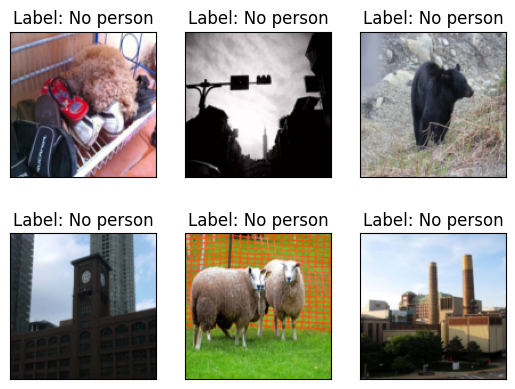

In [16]:
data_dir = "data/vww-s256/val"

val_data_loader = build_val_data_loader(data_dir, resolution=128, batch_size=1)

vis_x, vis_y = 2, 3
fig, axs = plt.subplots(vis_x, vis_y)

num_images = 0
for data, label in val_data_loader:
    # val_data_loader 中 data dtype：float32, 数值范围：通常是 [-1, 1]
    # 这在 CV 里非常常见, 例如我们dataloder function中有代码：
    # normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    # 当我想要打印出图片时需要将[-1, 1] 映射回到 [0, 255]
    img = np.array((((data + 1) / 2) * 255).numpy(), dtype=np.uint8)
    # img = img[0].transpose(1, 2, 0) 此操作为：去掉 batch 维度 + 把图像从 CHW 变成 HWC
    # 这是 PyTorch → NumPy → Matplotlib 之间最常见的维度转换。
    img = img[0].transpose(1, 2, 0)
    if label.item() == 0:
        label_text = "No person"
    else:
        label_text = "Person"
    axs[num_images // vis_y][num_images % vis_y].imshow(img)
    axs[num_images // vis_y][num_images % vis_y].set_title(f"Label: {label_text}")
    axs[num_images // vis_y][num_images % vis_y].set_xticks([])
    axs[num_images // vis_y][num_images % vis_y].set_yticks([])
    num_images += 1
    if num_images > vis_x * vis_y - 1:
        break

plt.show()